# Lecture 5
- Optimal Decisions for Discrete Stochastic Systems

In [18]:
import numpy as np
import numpy.random as npr
import random
import itertools

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')

## Optimal Decisions for Discrete Stochastic Systems

**Handwritten Example: Binary Communication System**


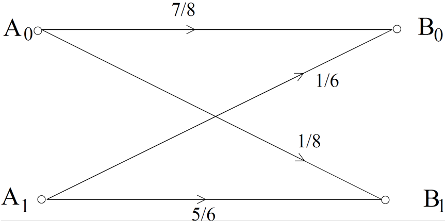

In [19]:
from IPython.display import Image
Image('figures/bcs.png',width=400)

In [20]:
import numpy as np

In [21]:
P = np.array([
    [7/8, 1/8],
    [1/6, 5/6]
])

In [22]:
np.sum( P, axis=1)

array([1., 1.])

In [23]:
np.sum(P, axis=0)

array([1.04166667, 0.95833333])

## Decision Problem and Decision Rules
 Let $\widehat{A}_i$ denote the event that the receiver decides that input was $A_i$. Then the ML decision rule given $B_j$ is observed is 

$$
\widehat{A}_i, \mbox{ where } i = \arg \max_{i \in \{0,1\}} P(B_j|A_i).
$$



The values of $P(B_j|A_i)$ are given in the figure.  For each output, the ML rule selects the input that has the largest likelihood, which corresponds to the arrow with the largest probability merging into that output in the figure. Similarly, the ML decision corresponds to the row number with the largest probability for each column of the transition probability matrix, $\mathbf{P}$. To get the index of the largest value in each column, we can use the `np.argmax()` function and pass the `axis=0` keyword parameter to tell NumPy to maximize over the rows. (Note that `np.max()` returns the maximum value, whereas `np.argmax()` returns the index of the maximum value.)

Thus, the ML decisions are as follows:




In [24]:
np.argmax(P, axis=0) # calculate the maximal i that generates the j-th observation.

array([0, 1])

We can read these decisions as follows. The value in position $j$ is the decision given $B_j$ is received. Then the decision rules are as follows:
* Given $B_0$ is received, decide $A_0$.
* Given $B_1$ is received, decide $A_1$. 

Suppose $P(A_0) =1$: 

Let $E$ be the event that an error occurs (i.e., the decision differs from the transmitted symbol). Then for this simple example, $P(E) =  P(B_1|A_0) = 0.125$. We know that it is suboptimal because we could just use the decision rule "Always decide $A_0$" and get error probability 0.

We can guess that there must be some value $q_0$ such that:
* if $P(A_0)<q_0$, the ML rule performs better, and
* if $P(A_0)>q_0$, always deciding $A_0$ performs better.

Let's build a simulation to test this. First, we will see how to efficiently generate the events $A_0$ and $A_1$ given any probabilities $P(A_0)$ and $P(A_1)$ such that $P(A_0)+P(A_1) = 1$. We will again use NumPy's `npr.choice()` function and pass on the probability as addtional variable.


Thus, if we want to output a 0 with probability $P(A_0)=0.75$ and a 1 with probability $P(A_1)=0.25$, we can simulate 1000 such events as follows:

Now we are ready to build a function to carry out the simulation:

In [14]:
def sim2to2 (decision_rule, P, PA0, num_sims = 10_000, verbose = True):
    # Create all the input events at the same time:
    inputs = npr.choice([0, 1], num_sims, p = [PA0, 1-PA0])
    
    # Create an array to determine the channel outputs
    obs = np.zeros(num_sims)
    # Create an array to store the decisions
    decisions = np.zeros(num_sims)
    # There are more efficient ways of doing this using NumPy, but
    # individually determining each output for each input should make 
    # this easier to understand for most learners
    for sim in range(num_sims):
        # Choose observation according to transition probabilities for given input bit:
        input_bit = inputs[sim]
        observation = npr.choice([0,1], p= P[input_bit]) 
        obs[sim]= observation
        # Now pass this observation to the decision_rule function: 
        decisions[sim] = decision_rule(observation, P, PA0)
    # Finally, calculate the error probability. An error occurs
    # whenever the decision is not equal to the true input
    errors = np.sum(inputs!=decisions)
    error_prob = errors/num_sims
    if verbose:
        print( f'The error probability is approximately {error_prob:.2f}')
    return error_prob

In [25]:
def always_decide0(observation, P, PA0):
    return 0

In [27]:
sim2to2(always_decide0, P, 0.5, verbose=True)

The error probability is approximately 0.50


0.498

In [28]:
def MLE (observation, P, PA0):
    return np.argmax(P[:, observation]) # select the column corresponding to P(B_j|A_i), i=0,1

In [30]:
sim2to2(MLE, P, 0.1, verbose=True)

The error probability is approximately 0.16


0.1649

In [31]:
sim2to2(MLE, P, 0.8, verbose=True)

The error probability is approximately 0.14


0.138

In [32]:
sim2to2(MLE, P, 0.5, verbose=True)

The error probability is approximately 0.14


0.1433

Let’s create one more decision rule function: always decide A1:

In [33]:
def always_decide1(observation, P, PA0):
    return 1

The following code calculates the error probabilities for these three decision rules as
a function of $P(A_0)$.

In [34]:
from tqdm import tqdm # show progress in computation

input_probs = np.linspace(0,1,21) # calculate 21 discrete points from 0,1, approximate the continuous probability value

pe_always0 = []
pe_always1 = []
pe_ML = []

for PA0 in tqdm(input_probs): 
    pe_always0 += [sim2to2(always_decide0, P, PA0)]
    pe_always1 += [sim2to2(always_decide1, P, PA0)]
    pe_ML += [sim2to2(MLE, P, PA0)]

100%|██████████| 21/21 [00:13<00:00,  1.55it/s]


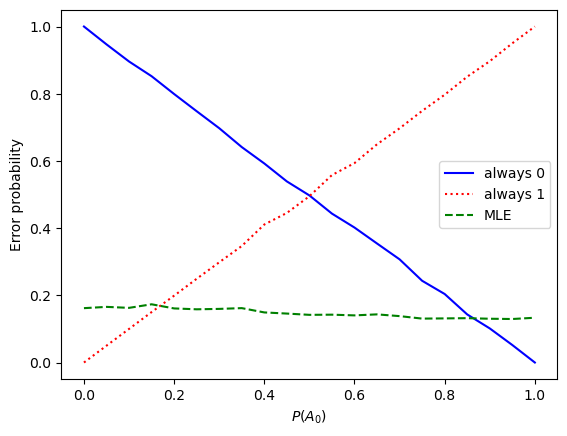

In [35]:
import matplotlib.pyplot as plt
plt.plot(input_probs, pe_always0, 'b-', label="always 0")
plt.plot(input_probs, pe_always1, 'r:', label="always 1")
plt.plot(input_probs, pe_ML, 'g--', label="MLE")

plt.legend()
plt.xlabel('$P(A_0)$')
plt.ylabel('Error probability');

# Decision Rules- MAP

<div class="alert alert-info" role="alert">
  <strong>Maximum A Posteriori (MAP) Decision Rule</strong>

If the set of events $\{A_0, A_1\}$ partitions $\Omega$, and assuming $P(A_i)>0$, for all $i$. Then the Maximum A Posteriori decision rule is given by:
    
\begin{align*}
P(A_0|B) &\underset{A_1}{\overset{A_0}{\gtrless}} P(A_1|B) \\
\iff \frac{P(B|A_0)P(A_0)}{P(B)} &\underset{A_1}{\overset{A_0}{\gtrless}} \frac{P(B|A_1)P(A_1)}{P(B)}
\end{align*}
    
</div>

The APPs can be computed by implementing Bayes’ rule in Python as follows for
$P(A_0) = 2/5$ and $P(A_1) = 3/5$

In [37]:
aprioris = np.array([2/5,3/5])
for j in range(2):
    pBj = 0
    for i in range(2):
        pBj += P[i, j]* aprioris[i]
        # complete the calculation of P(B_j)
    print(f'P(B{j}) = {pBj:.2f}: ', end = '')

    for i in range(2):
        # Complete the calculation of P(A_i|B_j)
        print(f'P(A{i}|B{j})={P[i,j]*aprioris[i]/pBj: .2f}',end=' ')       
    print()
    print()

P(B0) = 0.45: P(A0|B0)= 0.78 P(A1|B0)= 0.22 

P(B1) = 0.55: P(A0|B1)= 0.09 P(A1|B1)= 0.91 



It chooses $A_0$ if observing $B_0$, and choose $A_1$ if observing $B_1$.

From these example a prioris, we see that the MAP rule is not any of the three rules
previously introduced! Let’s create a MAP decision rule function:

In [39]:
def MAP(observation, P, PA0):
    # Take the jth column and multiply it elementwise by the
    # a priori probability vector
    scaled_apps = P[:, observation]*np.array([PA0, 1-PA0])
    return np.argmax(scaled_apps)

The following code simulates the performance of all of the decision rules discussed for
different values of the a priori probability P(A0).

In [40]:
input_probs = np.linspace(0,1,21)

pe_always0 = []
pe_always1 = []
pe_ML = []
pe_MAP = []

for PA0 in tqdm(input_probs):
    pe_always0 += [sim2to2(always_decide0, P, PA0)]
    pe_always1 += [sim2to2(always_decide1, P, PA0)]
    pe_ML += [sim2to2(MLE, P, PA0)]
    pe_MAP += [sim2to2(MAP, P, PA0)]

100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


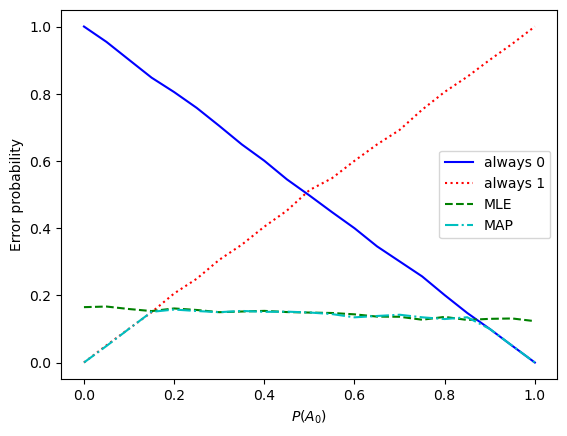

In [41]:
import matplotlib.pyplot as plt


plt.plot(input_probs, pe_always0, 'b-', label="always 0")
plt.plot(input_probs, pe_always1, 'r:', label="always 1")
plt.plot(input_probs, pe_ML, 'g--', label="MLE")
plt.plot(input_probs, pe_MAP, 'c-.', label="MAP")

plt.legend()
plt.xlabel('$P(A_0)$')
plt.ylabel('Error probability');

the MAP rule achieves the lowest error probability for all values of
$P(A_0)$. However, this requires the receiver to know the a priori values of the inputs. If the
a priori probabilities are not known, then the ML decision rule is usually used.